In [1]:
using Model
using Dictionaries, SplitApplyCombine
using DataFramesMeta, Dates
using CairoMakie, AlgebraOfGraphics
using StatsBase

In [2]:
decisions = Model.loaddata("../../data/processed/json_augmented");

In [4]:
(label ∘ senate)(first(decisions))

UndefVarError: UndefVarError: board not defined

In [5]:
Model.label(s::String) = s

function flatten_and_summarize(decisions, by)
    df = DataFrame(group=by.(decisions), outcome=label.(outcome.(decisions)))
    df = @chain df begin
        DataFrames.flatten(:group)
        groupby([:group, :outcome])
        combine(nrow => :count)
        groupby(:group)
        @transform(:n = sum(:count))
        @rtransform(:share = :count / :n)
        unstack([:group, :n], :outcome, :share)
        @rtransform(:group = label(:group))
        sort!(:n; rev=true)
    end
end;

# Figure 1: Yearly number of cases by outcome (A) and across boards (B), 2000 – 2020

In [46]:
map(group(label ∘ outcome, decisions)) do ds
    (;count=length(ds), share=round(length(ds) / length(decisions); digits=2))
end

3-element Dictionary{String, NamedTuple{(:count, :share), _A} where _A<:Tuple{Int64, Any}}
 "partially annulled" │ (count = 696, share = 0.57)
    "claim dismissed" │ (count = 295, share = 0.24)
           "annulled" │ (count = 236, share = 0.19)

In [183]:
decisions_from_board(decisions, board) = filter(d -> id(senate(d)) == board, decisions)

function plot_dates!(ax, ds, board; kwargs...)
    x = datetime2rata.(ds)
    xticks=(datetime2rata.(Date.(2000:5:2020)), string.(2000:5:2020))
    vlines!(ax, x; color=(:black, 0.8), kwargs...)
    ax.xticks = xticks
    ax.yticks = ([.5], ["Board $board"])
    ax.yticksvisible=false
    ax.ygridvisible=false
    ylims!(0, 1)
    return
end


plot_dates! (generic function with 2 methods)

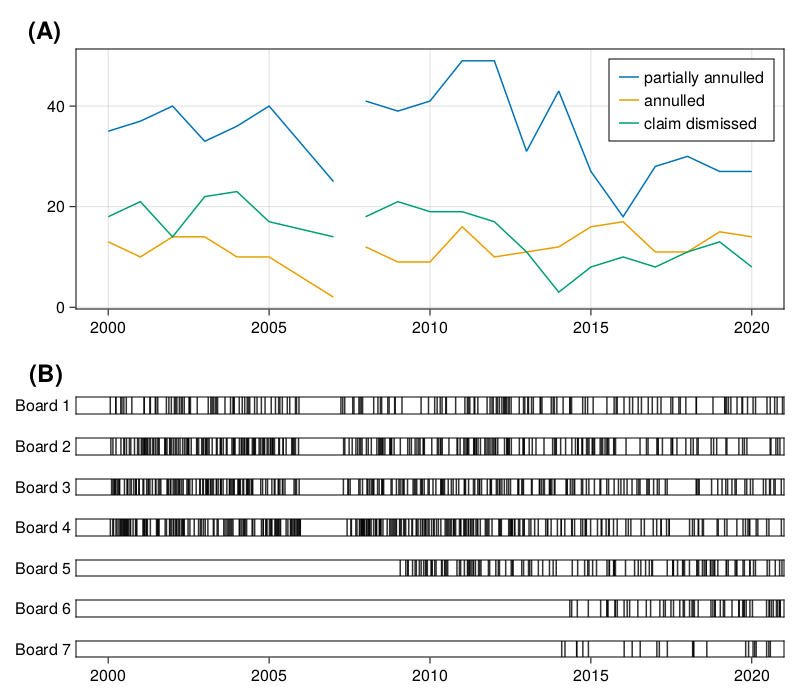

In [206]:
let df = DataFrame(year=Dates.year.(date.(decisions)), outcome=(label ∘ outcome).(decisions))
    df = combine(groupby(df, [:year, :outcome]), nrow => :count)
    
    order = ["partially annulled", "annulled", "claim dismissed"]
    append!(df, DataFrame(year=fill(2007, 3), outcome=order, count=fill(NaN, 3)); promote=true)
    sort!(df, :year)

    fig = Figure(resolution=(800, 700))
    gl1 = fig[1,1] = GridLayout()
    gl2 = fig[2,1] = GridLayout()

    # lineplot
    Label(gl1[1,1, TopLeft()]; text="(A)", fontsize=24, font=:bold, padding=(0,15,5,0))
    ax1 = Axis(gl1[1,1])

    for outcome in order
        dat = @rsubset df :outcome == outcome
        lines!(ax1, dat.year, dat.count; label=outcome)
    end

    axislegend(ax1)

    # events
    Label(gl2[1,1, TopLeft()]; text="(B)", fontsize=24, font=:bold, padding=(0,0,10,0))

    boards = 1:7
    for (i, board) in enumerate(boards)
        ax = Axis(gl2[i, 1]; xgridvisible=false)
        ds = decisions_from_board(decisions, board)
        plot_dates!(ax, date.(ds), board)
        xlims!(ax, datetime2rata.((Date(1999), Date(2021))))
        i != length(boards) && hidexdecorations!(ax)
    end

    fig
end

# Figure 2: Case load and outcomes by board

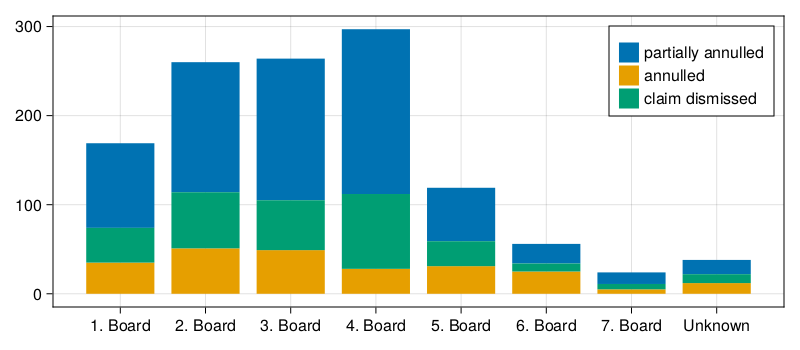

In [215]:
let df = DataFrame(senate=(label ∘ senate).(decisions), outcome=(label ∘ outcome).(decisions))
    df = combine(groupby(df, [:senate, :outcome]), nrow => :count)
    df.senate = replace.(df.senate, "0. Senate" => "Unknown")
    df.senate = replace.(df.senate, r"Senate" => "Board")

    order = ["partially annulled", "annulled", "claim dismissed"]
    plt = data(df) * mapping(:senate=>"", :count=>"", color=:outcome=>sorter(order)=>"", stack=:outcome) * visual(BarPlot)
    
    fig = Figure(resolution=(800, 350))
    p = draw!(fig, plt)
    legend!(fig[1,1], p; tellwidth=false, halign=:right, valign=:top, margin=(10, 10, 10, 10))
    fig
end

# Variation by judges and CPC classes

In [61]:
function plot_outcome_judge(df; title="", subtitle="")
    outcomes = ["claim dismissed" => "dismissed", 
                "partially annulled" => "partially annulled", 
                "annulled" => "annulled"]

    dftop = first(rename(df, outcomes), 30)
    dflong = DataFrames.stack(dftop, last.(outcomes))
    dflong.counts = dflong.value .* dflong.n

    judgeorder = sort!(dftop, :dismissed).group
    N = length(judgeorder)

    fig = Figure(resolution=(800, 450))

    pl1 = data(unique(dflong, [:group, :n])) * mapping(
            :group => sorter(judgeorder) => "", :n => "";
          ) * visual(BarPlot)

    axis = (;xticklabelsvisible=false, xgridvisible=false, 
            title, subtitle, titlealign=:left, titlesize=20, subtitlecolor=:grey50)

    gr1 = draw!(fig[1,1], pl1; axis)
    xlims!(0.2, length(judgeorder) + 0.8)

    order = ["partially annulled", "annulled", "dismissed"]

    pl2 = data(dflong) * mapping(
            :group => sorter(judgeorder) => "", :value => ""; 
            stack=:variable,# => sorter(order) => "", 
            color=:variable => sorter(order) => ""
          ) * visual(BarPlot)

    ax2 = axis=(;xticks=(1:N, string.(1:N)), xticklabelsize=10, xgridvisible=false)
      
    gr2 = draw!(fig[2,1], pl2;  axis=ax2)
    xlims!(0.2, length(judgeorder) + 0.8); ylims!(-0.01, 1.01)
    #legend!(fig[3,1], gr2; tellwidth=false, tellheight=true, orientation=:horizontal)

    rowsize!(fig.layout, 1, Relative(.4))
    
    fig
end;

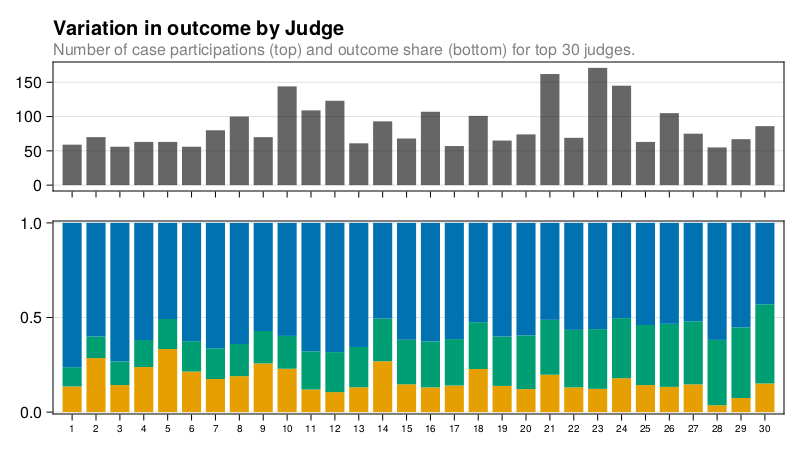

In [62]:
let df = flatten_and_summarize(decisions, judges)
    title = "Variation in outcome by Judge"
    subtitle = "Number of case participations (top) and outcome share (bottom) for top 30 judges."
    fig = plot_outcome_judge(df; title, subtitle)
    save("variation_judges.png", fig; px_per_unit=2)
    fig
end

In [153]:
using DataFramesMeta

let df = flatten_and_summarize(decisions, judges)
    @rsubset! df :n >= 50
    extrema(df.var"claim dismissed")
end

(0.1016949152542373, 0.46153846153846156)

In [59]:
function plot_outcome_tech(df; title="", subtitle="")
    outcomes = ["claim dismissed" => "dismissed", 
                "partially annulled" => "partially annulled", 
                "annulled" => "annulled"]

    dftop = first(rename(@rsubset(df, :group != "Y10"), outcomes), 30)
    dflong = DataFrames.stack(dftop, last.(outcomes))
    dflong.counts = dflong.value .* dflong.n

    order = sort!(dftop, :dismissed).group
    N = length(order)

    fig = Figure(resolution=(800, 450))

    pl1 = data(unique(dflong, [:group, :n])) * mapping(
            :group => sorter(order) => "", :n => "";
          ) * visual(BarPlot)

    axis = (;xticklabelsvisible=false, xgridvisible=false, 
            title, subtitle, titlealign=:left, titlesize=20, subtitlecolor=:grey50)

    gr1 = draw!(fig[1,1], pl1; axis)
    xlims!(0.2, N + 0.8)

    order_outcome = ["partially annulled", "annulled", "dismissed"]

    pl2 = data(dflong) * mapping(
            :group => sorter(order) => "", :value => ""; 
            stack=:variable ,# => sorter(reverse(order_outcome)) => "", 
            color=:variable => sorter(order_outcome) => ""
          ) * visual(BarPlot)

    ax2 = axis=(;xticklabelsize=10, xgridvisible=false)
      
    gr2 = draw!(fig[2,1], pl2;  axis=ax2)
    xlims!(0.2, N + 0.8); #ylims!(-0.01, 1.01)
    legend!(fig[3,1], gr2; tellwidth=false, tellheight=true, orientation=:horizontal)

    rowsize!(fig.layout, 1, Relative(.3))
    
    fig
end;

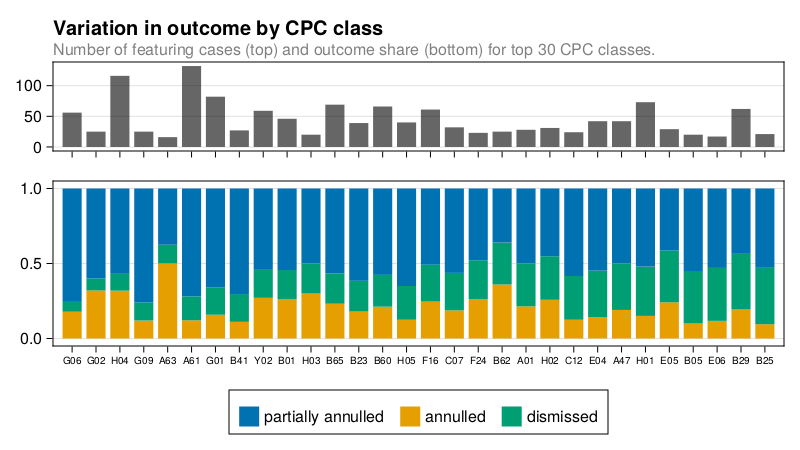

In [60]:
let df = flatten_and_summarize(decisions, class ∘ patent)
    title = "Variation in outcome by CPC class" 
    subtitle = "Number of featuring cases (top) and outcome share (bottom) for top 30 CPC classes."
    fig = plot_outcome_tech(df; title, subtitle)
    save("variation_tech.png", fig; px_per_unit=2)
    fig
end